### Let's see our CIFAR10 CNN model run on some images in the test set

In [1]:
#Import all the packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision

import numpy as np
import torch.nn.functional as F # useful stateless functions
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the CIFAR10 test dataset

NUM_TRAIN = 49000

transform = T.Compose([
                T.ToTensor(),
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])


cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64, shuffle=True)

Files already downloaded and verified


In [3]:
len(cifar10_test)

10000

In [4]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


using device: cuda


In [5]:
# Load the saved model

def CIFAR10_CNN():
    channel_1 = 32
    channel_2 = 32
    channel_3 = 64
    channel_4 = 64
    channel_5 = 128
    channel_6 = 128
    num_units_1 = 512
    num_units_2 = 256
    num_classes = 10
    bias = False
    dropout_prob = 0.4
    
    model = nn.Sequential(
            # Conv_1
                nn.Conv2d(3, channel_1, (5,5), padding=2, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_1),
            # Conv_2
                nn.Conv2d(channel_1, channel_2, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_2),
                nn.MaxPool2d(kernel_size=(2,2), stride=2),
                nn.Dropout2d(p=0.2),
            # Conv_3
                nn.Conv2d(channel_2, channel_3, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_3),
            # Conv_4
                nn.Conv2d(channel_3, channel_4, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_4),
                nn.MaxPool2d(kernel_size=(2,2), stride=2),
                nn.Dropout2d(p=0.3),
                #Flatten(),
            # Conv_5
                nn.Conv2d(channel_4, channel_5, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_5),
            # Conv_6
                nn.Conv2d(channel_5, channel_6, (3,3), padding=1, bias=bias),
                nn.ReLU(),
                nn.BatchNorm2d(num_features= channel_6),
                nn.MaxPool2d(kernel_size=(2,2), stride=2),
                nn.Dropout2d(p=dropout_prob),
            # Conv_7: Output layer
                nn.Conv2d(channel_6, 10, (4,4), padding=0, bias=True),
                Flatten())
    return model


model = CIFAR10_CNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

checkpoint = torch.load('./checkpoint_save')
model.load_state_dict(checkpoint['model_state_dict'])

In [6]:
# Verify the model's accuracy on the test set
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    model.to(device=device)  # move model to GPU
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc
_ = check_accuracy_part34(loader_test, model)

Checking accuracy on test set
Got 8669 / 10000 correct (86.69)


### Now lets run on individual images

No. of correctly predicted images out of 64 = 59


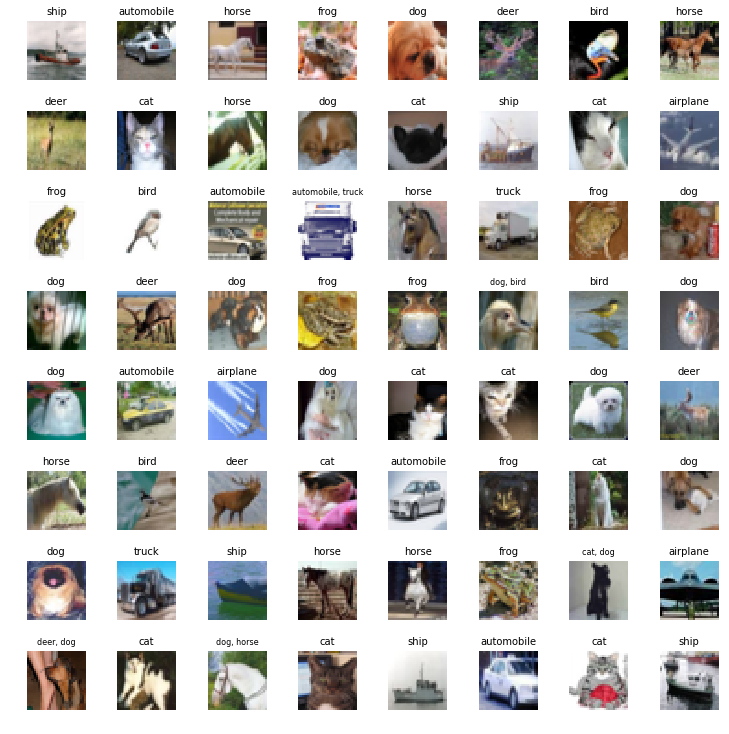

In [7]:
# list of the 10 classes
classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Run it on one batch
def batch_run(model, loader):
    model.eval()
    model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct = (preds == y).sum()
            
            print("No. of correctly predicted images out of 64 =", num_correct.cpu().numpy())
            
            # the target values of each image
            y = y.cpu()
            target = classes[y]
            
            # convert preds from int to string of corresponding class
            preds = preds.cpu()
            preds = classes[preds]
            
            # plot the images
            x = x.cpu()
            nrow = 8
            ncol = 8
            figure = plt.figure(figsize=(10,10))
            for i in range(loader.batch_size):
                subplot = figure.add_subplot(nrow, ncol, i+1)
                subplot.axis('off')
                if preds[i] == target[i]:
                    subplot.set_title(preds[i], fontsize=10)
                else:
                    subplot.set_title(preds[i] + ', ' + target[i], fontsize=8)
                plt.imshow(x[i].numpy().transpose(1,2,0))
            figure.tight_layout(pad=0, h_pad=None, w_pad=None, rect=(0,0,1,1))
            break
    return preds
preds = batch_run(model, loader_test)

For incorrectly predicted images, the correct label is also written after the predicted label